# Heat Equation

We are going to explore numerical schemes for the heat equation, which is given by

$$ \frac{\partial u} {\partial t} = a^2 \frac{\partial^2 u}{\partial x^2} + F(x)$$

where $a$ is the wave speed and $F(x) = \sin(5x)$. 

## Setup of the problem and the domain

We are going to consider the following:

Domain L: $ 0 \le x \le \pi$.

Initial Conditions $u(t=0,x) = x (\pi-x)$

Boundary Conditions: $u(t,x=0)=0$ and $u(t,x=\pi) = 0$

## Explicit Time Scheme

The is the FTCS (Forward in time, Central in Space): $ \mathrm{T.E.} = \mathcal{O}(\Delta t, \Delta x^2)$

$$ u^{n+1}_{i} -u^n_i = \frac{a^2 \Delta t}{\Delta x^2} \left ( u^n_{i+1} - 2u^n_{i} + u^n_{i-1} \right ) + \Delta t f(x_i) $$

where $f(x_i) = \sin(5x_i)$.

Now let's build the code!

### Import Libraries


In [1]:
import numpy as np
import matplotlib.pyplot as plt


### Defining parameters

In [2]:
#Wave spped
a = 0.5

#Number of grid pts
M = 101

#size of x domain
L = np.pi

#size of time domain
tend = 50
N = 50000


## Grid

We are going to build a simple uniform grid in one dimension


In [3]:
#setup grid
x = np.linspace(0,L,M)
dx = L/(M-1)
print (dx)


0.031415926535897934


### Stability

Now that we defined our grid with $\Delta x = \pi/100$ and the wave speed, $a =0.5$, we can assess the stability to find what time step is appropriate.

For this scheme we defined the Amplification Factor as

$$G = \lvert 1 - 4 r \sin^2\left (\frac{\beta}{2} \right ) \rvert \le 1 $$

where the CFL 

$$ r = \frac{a^2 \Delta t}{\Delta x^2} \le \frac{1}{2} $$.

where the $\max( \Delta t ) = 2 a^2 \Delta x^2 \approx 0.00049$ if $M = 101$ 

or 

$\max( \Delta t ) \approx 0.003$ if $M = 21$

Now we can set the time step

In [4]:
#set delta t
dt = .0001
time = 0.0


### Initialization

We need to initialize the flow field.  We define a function that initializes the data

In [5]:
def initialize_data(u, x):

   u[:] = x[:]*(np.pi-x[:])

### Spatial (RHS) Integration

Next, we need function that will integrate the RHS of the equation where

$$ RHS =  \frac{a^2 \Delta t}{\Delta x^2} \left ( u^n_{i+1} - 2u^n_{i} + u^n_{i-1} \right ) $$

The $RHS$ vector g is updated at each interior point

In [6]:
def calculate_space(u, g, a, dx):

    g[:] = 0.0

    for i in range(1, u.shape[0]-1):
       g[i] = (u[i+1] - 2*u[i] + u[i-1])

    g[:] *= a**2/dx**2


### Boundary Conditions

Now the boundary conditions need to be implemented

$$u_0 = 0$$

$$u_M = 0$$, where M is the last grid point

In [7]:
def apply_bcs(u, dt):

    u[0] = 0
    u[-1] = 0


### Force Term

The force term $f(x_i) = \sin(5x_i)$ needs to be implemented


In [8]:
def calculate_force(f,x):

    f[:] = np.sin(5*x)

### Explicit Time integration

The time integration function takes the space $g$ and force $f$ terms and integrates them over all interior points in the grid 

In [9]:
def advance_time(u, g, f, dt):

    for i in range(1, u.shape[0]-1):
       u[i] = u[i] + dt*(g[i] + f[i])

### Exact Solution

There is an exact solution to this problem

$$ u(x, t\rightarrow\infty) = \frac{1}{25a^2}\sin(5x) $$.  We can create a function to calculate this too

In [10]:
def calculate_exact(ue, a, x):

    ue[:] = 1.0 / (25*a**2) * np.sin(5*x)


### Error Calculation

Absolute error between the exact solution and the numerical solution is calculated as

$$ \epsilon_{abs} = \frac{1}{M} \sqrt{ \sum_{i=0}^M \left (u_e(x_i) - u(x_i) \right )^2 } $$

The relative error is

$$ \epsilon_{rel} = \epsilon_{abs}/ u_{mean}, $$

where $u_{mean} = \frac{1}{M} \sum_{i=0}^M u^2(x_i)$

In [11]:
def calculate_error(u, ue):

    eabs =  1.0/(u.shape[0]+1.0)*np.sqrt( np.sum( (ue - u)**2 ) )

    umean = (1.0/(u.shape[0]+1.0) * np.sum(u**2) )**0.5

    erel = eabs/umean

    return eabs, erel


### Main Loop

This is the driver of the entire solver.  We start with initializing the data and plot the initial condition.

(0, 3.141592653589793)

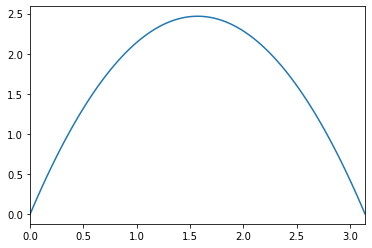

In [12]:
erel = 1

#create u, f vector
u = np.zeros_like(x)
g = np.zeros_like(x)
ue = np.zeros_like(x)
f = np.zeros_like(x)

#create array to hold solution at L/2
ul = np.zeros(N)
tt = np.arange(0, dt*N, dt)

#initialize the data
initialize_data(u, x)

#initial
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, u)
ax.set_xlim([0, np.pi])

In [13]:
for i in range(N):

    calculate_space(u, g, a, dx)
    calculate_force(f, x)
     
    advance_time(u, g, f, dt)

    apply_bcs(u, dt)

    time += dt

    calculate_exact(ue, a, x)
    
    erel_0 = erel
    eabs, erel = calculate_error(u, ue)
    
    ul[i] = u[int(M/2)]
    
    if (i % 100 == 0):
        print(i, dt, time, eabs, erel)
    
    #Exit Condtion
    if (abs(erel) < 1e-6):
         break



0 0.0001 0.0001 0.17691484882950645 0.09915990888198398
100 0.0001 0.010099999999999994 0.1764383129662676 0.0991399200234578
200 0.0001 0.020099999999999934 0.1759666741347712 0.09912098084813874
300 0.0001 0.030099999999999873 0.17549948963780693 0.09910303413833801
400 0.0001 0.04010000000000012 0.17503637626728488 0.09908602551198004
500 0.0001 0.05010000000000041 0.1745769976356645 0.09906990334149367
600 0.0001 0.060100000000000695 0.17412105704008607 0.0990546186559237
700 0.0001 0.07010000000000098 0.1736682921359179 0.0990401250365989
800 0.0001 0.08010000000000127 0.17321847059928058 0.09902637850999543
900 0.0001 0.09010000000000155 0.17277138646249549 0.09901333743986389
1000 0.0001 0.10010000000000184 0.17232685696138395 0.09900096242000224
1100 0.0001 0.11010000000000213 0.17188471979586087 0.09898921616865893
1200 0.0001 0.12010000000000241 0.17144483073562175 0.09897806342528048
1300 0.0001 0.130100000000002 0.17100706151971165 0.0989674708501218
1400 0.0001 0.140100000

### Plot Final


(0, 5.000000000001686)

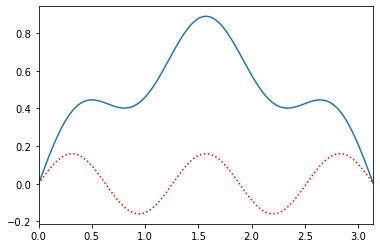

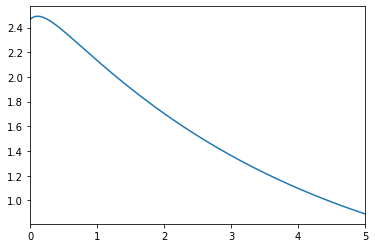

In [14]:
#final
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, u)
ax.plot(x,ue, 'r:')
ax.set_xlim([0, np.pi])


#u v t
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(tt, ul)
ax.set_xlim(0, time)


## Implicit Time Scheme

The is the FTCS (Forward in time, Central in Space): $ \mathrm{T.E.} = \mathcal{O}(\Delta t, \Delta x^2)$

$$ u^{n+1}_{i} -u^n_i = \frac{a^2 \Delta t}{\Delta x^2} \left ( u^{n+1}_{i+1} - 2u^{n+1}_{i} + u^{n+1}_{i-1} \right ) + \Delta t f(x_i) $$

where $f(x_i) = \sin(5x_i)$.

### Stability

The amplification factor for the the implicit scheme

$$ G = \lvert \frac{1}{1+4r\sin\left(\frac{\beta}{2} \right ) } \rvert \le 1 $$

where

$$ r = \frac{a^2 \Delta t}{\Delta x^2}  $$.

where the $\max( \Delta t ) = 2 a^2 \Delta x^2 \rightarrow \infty$

### Thomas Algorithm

This is the workhorse of the implicit time scheme.  It works for only a tri-diagonal matrix and is accomplished by Gaussian Elimination.  It works in $\mathcal{O}(n)$ iterations rather than $\mathcal{O}(n^3)$.

$$a_i x_{i - 1}  + b_i x_i  + c_i x_{i + 1}  = d_i , \,\!$$

where $ a_1  = 0\,$ and $ c_n = 0\, $.

$$
\begin{bmatrix}
   {b_1} & {c_1} & {   } & {   } & { 0 } \\
   {a_2} & {b_2} & {c_2} & {   } & {   } \\
   {   } & {a_3} & {b_3} & \ddots & {   } \\
   {   } & {   } & \ddots & \ddots & {c_{n-1}}\\
   { 0 } & {   } & {   } & {a_n} & {b_n}\\
\end{bmatrix}
\begin{bmatrix}
   {x_1 }  \\
   {x_2 }  \\
   {x_3 }  \\
   \vdots   \\
   {x_n }  \\
\end{bmatrix}
=
\begin{bmatrix}
   {d_1 }  \\
   {d_2 }  \\
   {d_3 }  \\
   \vdots   \\
   {d_n }  \\
\end{bmatrix}
.$$

In [15]:
## Tri Diagonal Matrix Algorithm(a.k.a Thomas algorithm) solver
def TDMAsolver(a, b, c, d):
    '''
    TDMA solver, a b c d can be NumPy array type or Python list type.
    refer to http://en.wikipedia.org/wiki/Tridiagonal_matrix_algorithm
    '''
    nf = len(a)     # number of equations
    ac, bc, cc, dc = map(np.array, (a, b, c, d))     # copy the array
    for it in range(1, nf):
        mc = ac[it]/bc[it-1]
        bc[it] = bc[it] - mc*cc[it-1]
        dc[it] = dc[it] - mc*dc[it-1]

    xc = ac
    xc[-1] = dc[-1]/bc[-1]

    for il in range(nf-2, -1, -1):
        xc[il] = (dc[il]-cc[il]*xc[il+1])/bc[il]

    del bc, cc, dc  # delete variables from memory

    return xc


### Advance in Time and Space

We need to write the equation in for the Thomas Algorithm.

We need to have three of the three diagonals in arrays

This is for $u_{i-1}$:
$$ a_i = -a^2 \frac{\Delta t}{\Delta x^2} u_i $$

$u_i$:
$$ b_i = 2a^2 \frac{\Delta t}{\Delta x^2} u + 1 $$

$u_{i+1}$:
$$ c_i = -a^2 \frac{\Delta t}{\Delta x^2} u_i $$

The RHS vector $d$:
$$d = \Delta t f(x_i) + u_i$$

We add the boundary conditions directly into the solver

In [16]:
def advance_time2(u, f, a, dt, dx):

    aa = np.ones_like(u) * -a**2*dt/dx**2
    bb = np.ones_like(u) * 2*a**2*dt/dx**2 + 1.0
    cc = np.ones_like(u) * -a**2*dt/dx**2

    dd = dt*f + u

    #apply u(0) = 0
    bb[0] = 1
    cc[0] = 0
    dd[0] = 0

    #apply u(L) = 0
    bb[-1] = 1
    aa[-1] = 0
    dd[-1] = 0

    u[:] = TDMAsolver(aa, bb, cc, dd)


### Initalize


(0, 3.141592653589793)

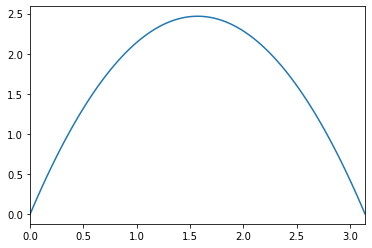

In [17]:
#create u, f vector
u = np.zeros_like(x)
g = np.zeros_like(x)
ue = np.zeros_like(x)
f = np.zeros_like(x)

#initialize the data
initialize_data(u, x)

#set delta t
dt = 10
time = 0.0

#create array to hold solution at L/2
ul = np.zeros(N)
tt = np.arange(0, dt*N, dt)

#initial
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, u)
ax.set_xlim([0, np.pi])


### Main Loop


In [18]:
for i in range(N):

    calculate_force(f, x)

    advance_time2(u, f, a, dt, dx)

    time += dt

    calculate_exact(ue, a, x)

    eabs, erel = calculate_error(u, ue)

    ul[i] = u[int(M/2)]

    print(i, dt, time, eabs, erel)

    #Exit condition
    if (eabs < 1e-4 or np.isnan(eabs) ):
        break


0 10 10.0 0.05044178864213243 0.09675677984377588
1 10 20.0 0.014412537968626037 0.07841383742106388
2 10 30.0 0.0041181675151496485 0.03440123759948539
3 10 40.0 0.001176891916612809 0.010426015588960247
4 10 50.0 0.00033698584904724683 0.003000647620243274
5 10 60.0 9.874265357394401e-05 0.0008796107089524708


(0, 3.141592653589793)

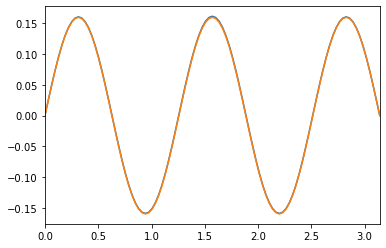

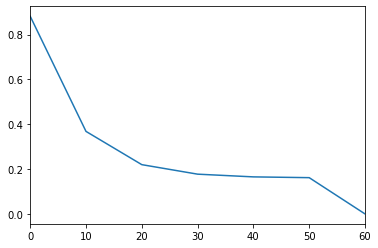

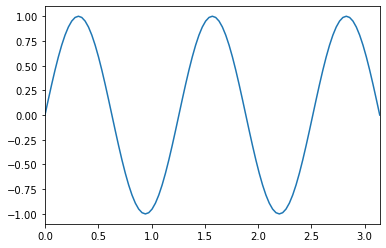

In [19]:
#final
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, u)
ax.plot(x, ue)
ax.set_xlim([0, np.pi])

#u v t
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(tt, ul)
ax.set_xlim(0, time)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, f)
ax.set_xlim([0, np.pi])



## Crank-Nicolson Scheme

This is a mixed scheme: $\mathrm{T.E.} = \mathcal{O}(\Delta t^2, \Delta x^2) $

$$ u^{n+1}_{i} -u^n_i = \frac{a^2 \Delta t}{2 \Delta x^2} \left ( u^{n+1}_{i+1} - 2u^{n+1}_{i} + u^{n+1}_{i-1} \right ) + \left ( u^{n}_{i+1} - 2u^{n}_{i} + u^{n}_{i-1} \right )+ \Delta t f(x_i) $$


In [20]:
def advance_time3(u, f, a, dt, dx):

    aa = np.ones_like(u) * -0.5*a**2*dt/dx**2
    bb = np.ones_like(u) * a**2*dt/dx**2 + 1.0
    cc = np.ones_like(u) * -0.5*a**2*dt/dx**2

    dd = dt*f + u
    for i in range(1, u.shape[0]-1):
        dd[i] += 0.5*a**2*dt/dx**2*u[i-1] - \
                 a**2*dt/dx**2*u[i]  + \
                 0.5*a**2*dt/dx**2*u[i+1]

    #apply u(0) = 0
    bb[0] = 1
    cc[0] = 0
    dd[0] = 0

    #apply u(L) = 0
    bb[-1] = 1
    aa[-1] = 0
    dd[-1] = 0

    u[:] = TDMAsolver(aa, bb, cc, dd)


(0, 3.141592653589793)

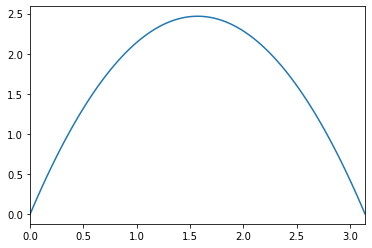

In [24]:
 #create u, f vector
u = np.zeros_like(x)
g = np.zeros_like(x)
ue = np.zeros_like(x)
f = np.zeros_like(x)

#initialize the data
initialize_data(u, x)


#create array to hold solution at L/2
ul = np.zeros(N)
tt = np.arange(0, dt*N, dt)

#initial
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, u)
ax.set_xlim([0, np.pi])



### Main Loop

In [26]:
for i in range(N):

        calculate_force(f, x)

        advance_time3(u, f, a, dt, dx)

        time += dt

        calculate_exact(ue, a, x)

        eabs, erel = calculate_error(u, ue)

        ul[i] = u[int(M/2)]

        print(i, dt, time, eabs, erel)

        #Exit condition
        if (eabs < 1e-4 or np.isnan(eabs) ):
            break


0 10 70.0 0.022314329588328477 0.07700119364083173
1 10 80.0 0.009921830879820074 0.17190188169109877
2 10 90.0 0.008913013382884446 0.045240635671095424
3 10 100.0 0.008157610788230572 0.16640302165149023
4 10 110.0 0.007571716728966423 0.040836923852854555
5 10 120.0 0.00696923640832995 0.13628560678190005
6 10 130.0 0.0065102336012979834 0.03701429977056733
7 10 140.0 0.0060124183458233815 0.10717583007659297
8 10 150.0 0.005643646673016023 0.033623078976133446
9 10 160.0 0.005221858052116268 0.084448551888066
10 10 170.0 0.004919857246434316 0.030564706364598546
11 10 180.0 0.004555626547389204 0.06753010495306815
12 10 190.0 0.004305058180328967 0.02777399686814963
13 10 200.0 0.003986130668592971 0.054862511269762174
14 10 210.0 0.00377662406689107 0.0252098831418312
15 10 220.0 0.00349453666895658 0.04518694258373305
16 10 230.0 0.003318774176989591 0.022846865479604257
17 10 240.0 0.0030674070388655374 0.03763765627131431
18 10 250.0 0.002919981983674572 0.020668643875636557
19

(0, 880.0)

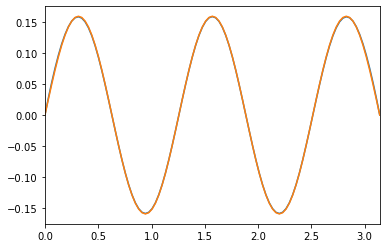

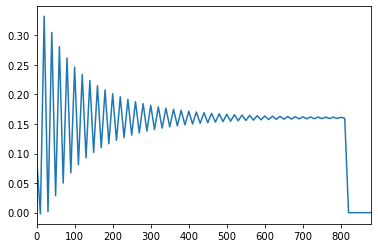

In [27]:
#final
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, u)
ax.plot(x, ue)
ax.set_xlim([0, np.pi])

#u v t
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(tt, ul)
ax.set_xlim(0, time)
